In [23]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025])

In [3]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
g_m = nx.from_numpy_array(WN)
g_m.remove_edges_from(nx.selfloop_edges(g_m))
neighbours = list(g_m.neighbors(1858))
second_neighbours = []
for n in neighbours:
    s_n = list(g_m.neighbors(n))
    second_neighbours.extend(s_n)
second_neighbours = list(set(second_neighbours))
all_neighbours = neighbours + second_neighbours
position = list(set(all_neighbours))

In [11]:
# Create a graph from mobility matrix
GM = nx.subgraph(nx.from_numpy_array(WN), position)#nx.from_numpy_array(WN)
A_s = nx.adjacency_matrix(GM).todense()

In [4]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [24]:
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [5]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [49]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
for r_idx in range(9):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] * prob_2d
        matrix = torch.from_numpy(g_i_new)

        y = torch.tensor([r_c], dtype=torch.long)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

20.0 0
10.0 0
2.0 1
1.0 1
0.5 1
0.2 2
0.1 2
0.05 3
0.025 3


In [54]:
from torch.utils.data import random_split
train_data, test_data = random_split(dataset, [int(2700*0.8), int(2700*0.2)])

In [55]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)        
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.classifier = Linear(16, num_classes)



    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        x = self.conv1(x, edge_index)
        x = F.relu(x) ### 

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.classifier(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50, num_classes=4).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        loss = F.cross_entropy(output, label)     
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        optimizer.step() 
        
        results.append(output)
        
        _, predicted = torch.max(output, 1)  
        total += label.size(0)  
        correct += (predicted == label).sum().item()  
    accuracy = 100 * correct / total
    return loss_all / len(myloader.dataset), accuracy, results, y_true


loss_ep = []
ac_ep = []
for epoch in range(100):
    loss,ac,myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
    ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}, ac: {:.5f}'.format(epoch, loss, ac))

Epoch: 000, Loss: 1.37880, ac: 31.38889
Epoch: 001, Loss: 1.36972, ac: 33.61111
Epoch: 002, Loss: 1.35976, ac: 33.61111
Epoch: 003, Loss: 1.34196, ac: 33.61111
Epoch: 004, Loss: 1.29245, ac: 37.82407
Epoch: 005, Loss: 1.23252, ac: 40.64815
Epoch: 006, Loss: 1.19694, ac: 40.97222
Epoch: 007, Loss: 1.10846, ac: 47.12963
Epoch: 008, Loss: 1.03071, ac: 49.90741
Epoch: 009, Loss: 0.96521, ac: 56.15741
Epoch: 010, Loss: 1.13609, ac: 42.82407
Epoch: 011, Loss: 1.04228, ac: 49.44444
Epoch: 012, Loss: 0.89668, ac: 57.63889
Epoch: 013, Loss: 0.84423, ac: 62.03704
Epoch: 014, Loss: 0.89762, ac: 58.00926
Epoch: 015, Loss: 0.86348, ac: 59.58333
Epoch: 016, Loss: 0.75890, ac: 67.63889
Epoch: 017, Loss: 0.82692, ac: 62.08333
Epoch: 018, Loss: 0.85412, ac: 58.56481
Epoch: 019, Loss: 0.78743, ac: 62.08333
Epoch: 020, Loss: 0.78000, ac: 63.19444
Epoch: 021, Loss: 0.75050, ac: 66.43519
Epoch: 022, Loss: 0.77007, ac: 63.75000
Epoch: 023, Loss: 0.68918, ac: 70.50926
Epoch: 024, Loss: 0.74452, ac: 64.76852


In [58]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [59]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_test = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            data, label = data.to(device), data.y.to(device)
            output = model(data)

            # Calculate loss
            loss = F.cross_entropy(output, label)
            test_loss += loss.item() * data.size(0)
            
            # Convert label to one-hot encoding
            one_hot_label = torch.zeros(label.size(0), 4).to(device)  # assuming 4 classes
            one_hot_label.scatter_(1, label.unsqueeze(1), 1)  # in-place operation to convert to one-hot
            y_test.extend(one_hot_label.cpu().numpy().tolist())
            
            # Store the scores
            y_scores.extend(output.cpu().numpy().tolist())

            # Get predictions
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    print(f"Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

    return avg_loss, accuracy, y_test, y_scores

# Assuming you have a test_loader, model, and criterion already defined
test_loss, test_accuracy, y_test, y_score = test(model, testloader)

Test set: Average loss: 1690.3152, Accuracy: 430/540 (79.63%)


In [60]:
from sklearn.metrics import roc_curve, auc
n_classes = 4
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
labels = {0:r'NS: $r > 5$',1:r'MS: $r \in [0.5,5]$',2:r'ES: $r \in (0.5,0.1]$',3:r'IS: $r<0.1$'}

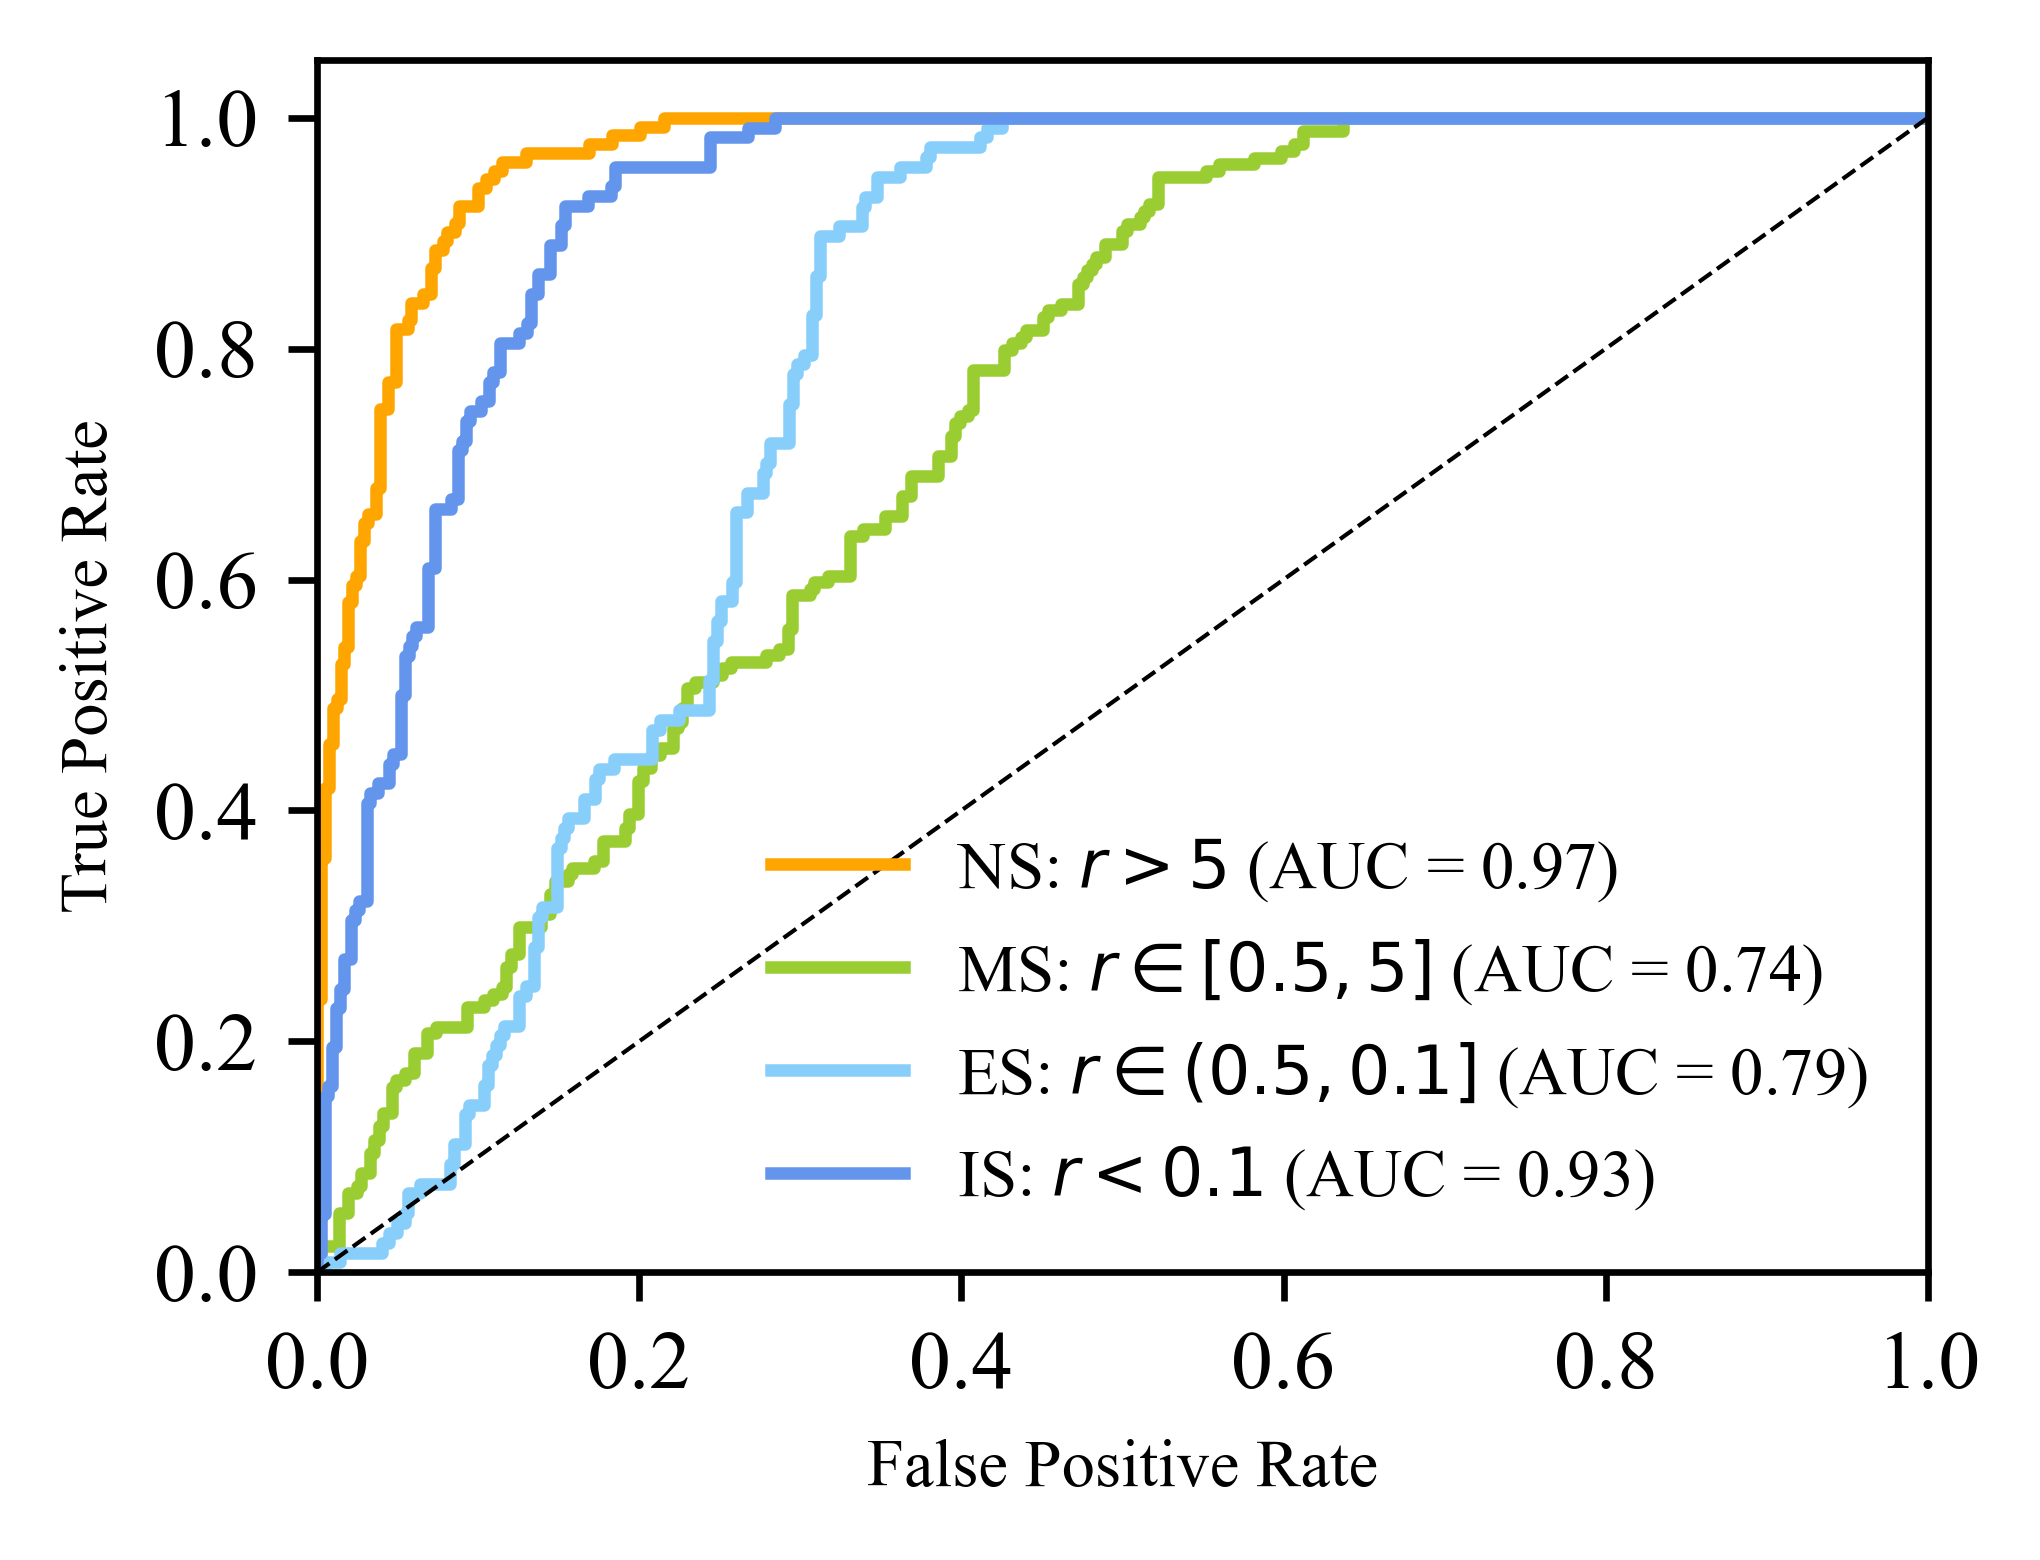

In [62]:
# y_test = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,0,0,0]])
# y_score = np.array([[0.5,0.2,0.1,0.2], [0.1,0.5,0.2,0.2], [0.2,0.1,0.5,0.2], [0.2,0.1,0.2,0.5], [0.6,0.1,0.1,0.2]])


y_test = np.array(y_test)
y_score = np.array(y_score)
fpr = dict()
tpr = dict()

smoothed_fpr = dict()
smoothed_tpr = dict()

roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#     smoothed_tpr[i] = moving_average(tpr[i], 5)
#     smoothed_fpr[i] = moving_average(fpr[i], 5)

# Plot the ROC curve
plt.rcParams['font.family'] = 'Times New Roman' 
plt.figure(dpi=600,figsize=(3.5,2.7))
for i in range(n_classes):
#     plt.plot(smoothed_fpr[i], smoothed_tpr[i], color = colors[i],
#              label='Class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))
    plt.plot(fpr[i], tpr[i], color = colors[i],
             label='{0} (AUC = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',lw=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',size=8)
plt.ylabel('True Positive Rate',size=8)
# plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=8,frameon=False)
plt.tight_layout()
plt.show()
# plt.savefig('roc.pdf')